In [1]:
# Recursive and Recursive with Cross validation Wrapper Selection
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

In [2]:
# Load data
X, y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(X, columns=load_breast_cancer().feature_names)
X.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
# Create logistic regression model
model = LogisticRegression(max_iter=5000)

In [5]:
# RFE: Select top 5 features recursively
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X_train, y_train)

selected_rfe = X.columns[rfe.get_support()]
print("RFE Chosen Features:", list(selected_rfe))

# Train and evaluate model with RFE-selected features
model.fit(X_train[selected_rfe], y_train)
y_pred_rfe = model.predict(X_test[selected_rfe])
acc_rfe = accuracy_score(y_test, y_pred_rfe)

print(f"Accuracy with RFE (5 features): {acc_rfe:.4f}")


RFE Chosen Features: ['mean radius', 'texture error', 'worst radius', 'worst compactness', 'worst concavity']
Accuracy with RFE (5 features): 0.9790


In [6]:
# RFECV: Automatically determines the optimal number of features using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    min_features_to_select=1
)
rfecv.fit(X_train, y_train)

selected_rfecv = X.columns[rfecv.get_support()]
optimal_features = rfecv.n_features_

print("RFECV Chosen Features:", list(selected_rfecv))
print(f"Optimal number of features selected by RFECV: {optimal_features}")

# Train and evaluate model with RFECV-selected features
model.fit(X_train[selected_rfecv], y_train)
y_pred_rfecv = model.predict(X_test[selected_rfecv])
acc_rfecv = accuracy_score(y_test, y_pred_rfecv)

print(f"Accuracy with RFECV (optimal features): {acc_rfecv:.4f}")

RFECV Chosen Features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'concavity error', 'concave points error', 'symmetry error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Optimal number of features selected by RFECV: 28
Accuracy with RFECV (optimal features): 0.9650


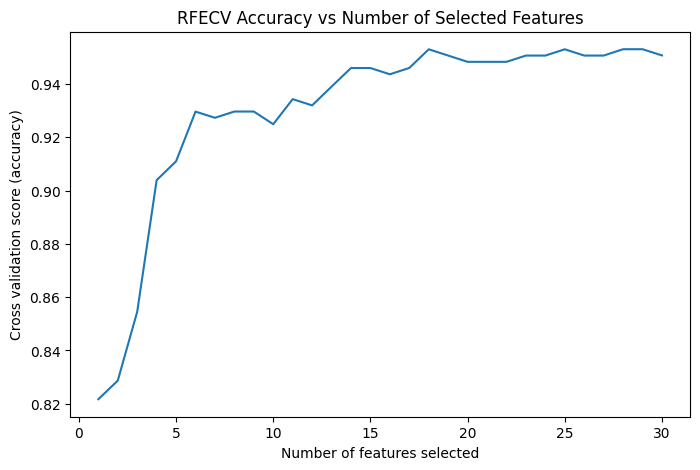

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
   rfecv.cv_results_['mean_test_score']
)
plt.title("RFECV Accuracy vs Number of Selected Features")
plt.show()


## RFE & RFECV Feature-Selection Enhancements

### 1. Automated Feature-Count Tuning (RFE)

**Purpose:**  
Automatically determine the best number of features (`k`) by evaluating cross-validated accuracy for each `k` using RFE.

**Key Changes:**
- Loop over `k` from 1 to `n_features`.
- Instantiate `RFE(estimator=model, n_features_to_select=k)`.
- Use `cross_val_score` with `StratifiedKFold` for each `k`.
- Track and select the `k` with highest mean CV accuracy.

**Impact:**  
Eliminates manual choice of feature count; RFE picks the optimal subset size for best accuracy.

---

### 2. Stratified K-Fold Integration (RFE)

**Purpose:**  
Maintain class balance in each fold when tuning RFE.

**Key Changes:**
- Create `cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`.
- Pass `cv=cv` into `cross_val_score(rfe, X, y, cv=cv, ...)`.

**Impact:**  
Ensures reliable RFE evaluation by preserving target-class proportions across folds.

---

### 3. Custom Scoring Functions (RFE)

**Purpose:**  
Optimize feature selection for metrics beyond accuracy—e.g., F1-score or balanced accuracy.

**Key Changes:**
- Replace `scoring='accuracy'` with `scoring='f1'` or `scoring='balanced_accuracy'` in `cross_val_score`.

**Impact:**  
Yields feature subsets tailored to specific performance goals, such as better handling of imbalanced classes.

---

### 4. Application to a New Dataset (Iris) (RFE)

**Purpose:**  
Demonstrate that the automated RFE pipeline generalizes to other datasets.

**Key Changes:**
- Load Iris  `X_iris, y_iris = load_iris(return_X_y=True)`.
- Adjust loop range to `range(1, X_iris.shape[1] + 1)`.
- Reuse the same RFE + StratifiedKFold + scoring logic.

**Impact:**  
Validates that the RFE tuning workflow can be applied without structural changes across domains.

---

## RFECV: One-Step Recursive Elimination with CV

### 1. Automated Feature-Count Tuning (RFECV)

**Purpose:**  
Combine RFE and cross-validation in a single step to find the optimal number of features.

**Key Changes:**
- Instantiate `RFECV(estimator=model, cv=cv, scoring='accuracy', step=1, min_features_to_select=1)`.
- Call `rfecv.fit(X, y)` to automatically tune `k`.

**Impact:**  
Simplifies pipeline by removing manual loops—RFECV directly returns the best `k` and mask.

---

### 2. Stratified K-Fold Integration (RFECV)

**Purpose:**  
Ensure class-balanced folds within RFECV.

**Key Changes:**
- Pass the same `cv = StratifiedKFold(...)` into `RFECV(cv=cv, ...)`.

**Impact:**  
Preserves target-class distribution during recursive elimination and CV.

---

### 3. Custom Scoring Functions (RFECV)

**Purpose:**  
Select features using alternative metrics in RFECV.

**Key Changes:**
- Change `scoring='accuracy'` to `scoring='f1'` or `'balanced_accuracy'` in `RFECV`.

**Impact:**  
Optimizes RFECV feature selection for the chosen performance metric.

---

### 4. Application to a New Dataset (Iris) (RFECV)

**Purpose:**  
Show generality of RFECV on a different dataset.

**Key Changes:**
- Load Iris: `X_iris, y_iris = load_iris(...)`.
- Fit `rfecv_iris = RFECV(estimator=model, cv=cv, scoring='accuracy')` on `X_iris, y_iris`.

**Impact:**  
Demonstrates that RFECV’s one-step tuning works across datasets with minimal changes.